In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import regularizers
from keras import backend as K
from tensorflow.keras import layers

print(tf.__version__)

2.1.0
Using TensorFlow backend.


# Well Dataset

In [3]:
dataset = pd.read_csv('data_all.csv')
#dataset = dataset[:7516]       #well_1
dataset = dataset[7517:13163]  #well_2 from 2-> 8120
#dataset = dataset[13164:]      #well_3
#dataset = dataset[:13163]  #well_1&2 from
#ignore = dataset[(dataset.ROP_time > 60) & ((dataset.For == 1) | (dataset.For == 2)) ]
#dataset = dataset.drop(ignore.index)
dataset = dataset[dataset.For > 3]

In [4]:
for i in range(1,12):
    print(i," => ",dataset[dataset.For == i].shape)
dataset.describe()

1  =>  (0, 13)
2  =>  (0, 13)
3  =>  (0, 13)
4  =>  (459, 13)
5  =>  (611, 13)
6  =>  (271, 13)
7  =>  (433, 13)
8  =>  (474, 13)
9  =>  (869, 13)
10  =>  (746, 13)
11  =>  (373, 13)


,For,DEPTH,Bit_Position,WOB_Max,WOB_Avg,WOB_Min,Torque_Max,Torque_Avg,Torque_Min,SPP_Avg,RPM_Avg,Flow_In_Pumps_Avg,ROP_time
count,4236.000000,4236.000000,4236.000000,4236.000000,4236.000000,4236.0,4236.000000,4236.000000,4236.000000,4236.000000,4236.000000,4236.000000,4236.000000
mean,7.725212,1831.762099,1831.761025,12.840179,10.270977,0.0,13046.684608,8538.124053,4291.792729,1711.540818,147.549940,2748.216593,21.293768
std,2.240032,469.620783,469.621940,2.482658,2.820996,0.0,3488.493516,2429.723678,2147.481337,208.355876,25.011635,153.438556,21.120648
min,4.000000,933.010000,933.010000,0.000000,0.000000,0.0,2971.000000,617.500000,0.000000,1180.916667,31.583333,1442.250000,0.600000
25%,5.000000,1483.485000,1483.485000,12.000000,8.670000,0.0,10327.250000,6961.062500,2883.500000,1492.230000,139.920000,2800.750000,5.400000
50%,8.000000,1945.430000,1945.430000,13.000000,10.750000,0.0,13167.500000,8269.500000,4228.500000,1801.500000,152.750000,2819.250000,13.200000
75%,10.000000,2252.012500,2252.012500,15.000000,12.420000,0.0,16648.250000,9960.416667,5556.500000,1894.710000,166.080000,2836.500000,30.000000
max,11.000000,2434.160000,2434.160000,44.000000,16.916667,0.0,18341.000000,16295.416670,14316.000000,1986.250000,174.000000,3128.830000,124.200000


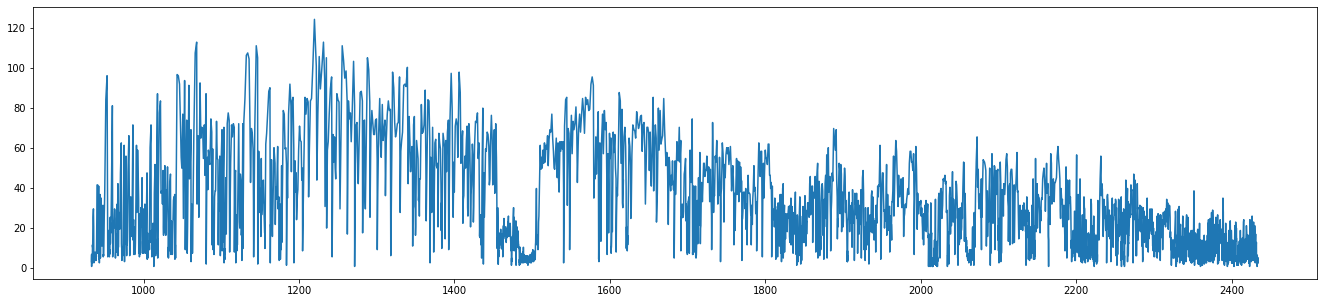

In [8]:
plt.figure(figsize=(23, 5))
plt.plot(dataset.DEPTH,dataset.ROP_time)

## the impact of RPM over ROP

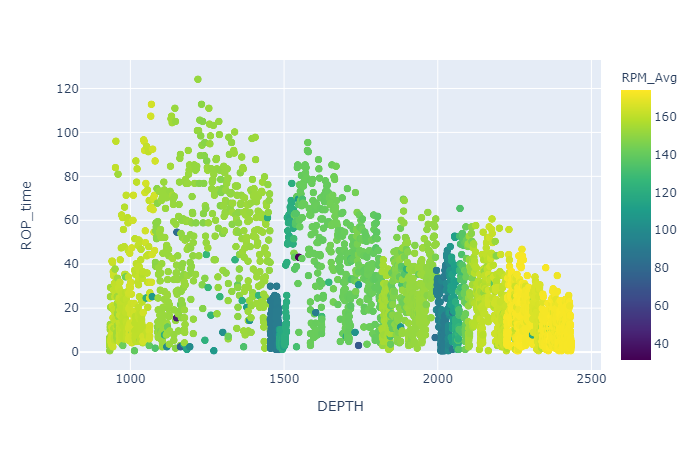

In [5]:
import plotly.express as px
df = px.data.tips()
fig = px.scatter(dataset, x="DEPTH", y="ROP_time", color="RPM_Avg",width=1300, 
           color_continuous_scale=px.colors.sequential.Viridis, render_mode="webgl")
fig.show("png")

# Machine learning model
`adam` optimizer wish have a better performance is used to calculate the gradient decet. 

`l2 regularizer` to add some noise to the model in order to reduce the overfitting.

`activativaion functions` for regression relu / elu / selu / leakyRleu.

`initialization` of weight and biases there are several algorithms such as he_normal...

`epoch`  we'll use an *EarlyStopping callback* that tests a training condition for  every epoch. automatically stop training when the validation score doesn't improve.

In [6]:

columns = [ 'For', 'DEPTH', 'Bit_Position', 'WOB_Max', 'WOB_Avg', 'WOB_Min',
            'Torque_Max', 'Torque_Avg', 'Torque_Min', 'SPP_Avg', 'RPM_Avg',
            'Flow_In_Pumps_Avg', 'ROP_time']

to_remove = ['For', 'WOB_Min']
rop = "ROP_time"
validation = 0.2
training = 0.8
history = None
annotations = [dict(xref='paper', yref='paper', x=0.0, y=1.05,
                        xanchor='left', yanchor='bottom',
                        text='ROP prediction',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(37,37,37)'),
                        showarrow=False)]

def norm(x,d):
    return 2*(x-d['min'])/(d['max']-d['min']) -1

def graph(test_rop, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_rop, test_predictions, color='blue')
    plt.xlabel('True Values [ROP]')
    plt.ylabel('Predictions [ROP]')
    lims = [-10, 60]
    plt.xlim(lims)
    plt.ylim(lims)
    return plt.plot(lims, lims ,color='red')


def get_optimizer(N_TRAIN):
    BATCH_SIZE = 1879
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.003,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=0.9,
    staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)


def build_model(lenth,hidden,layer,data_len):
    #init = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None) #'he_normal' / tf.keras.initializers.GlorotNormal()
    activation = tf.keras.layers.LeakyReLU() #'elu' 
    #optimizer = get_optimizer(data_len)
    #optimizer = tf.keras.optimizers.RMSprop()
    optimizer = tf.keras.optimizers.Adam(0.002)
    #optimizer = tfa.optimizers.AdamW(0.001)
    model = None
    regularizer = regularizers.l2(0.01)
    #init = tf.keras.initializers.GlorotNormal()
    init = 'he_normal' 
    #activation = 'relu'

    if layer == 5:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(1)
        ])
    
    elif layer == 4:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(1)
        ])

    
    elif layer == 3:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(1)
        ])

    elif layer == 2:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(1)
        ])

    elif layer == 1:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, kernel_regularizer=regularizer),
            layers.Dense(1)
        ])
        
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

    #model.compile(loss='mse',optimizer=optimizer,metrics=[coeff_determination])
    #              metrics=['mae', 'mse'])
    return model

def ml(i,hidden=18,layer=1):
    ds = dataset#[dataset.For != 4]
    target = list( set(dataset.columns) - set(to_remove))
    ds = ds[target]

    train_dataset = ds.sample(frac=training,random_state=0) # shufled  
    test_dataset = ds.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop('ROP_time')
    train_stats = train_stats.transpose()

    train_rop = train_dataset.pop(rop)
    test_rop = test_dataset.pop(rop)

    
    normed_train_data = norm(train_dataset,train_stats)
    normed_test_data = norm(test_dataset,train_stats)

    model = build_model(len(train_dataset.keys()),hidden,layer,len(normed_train_data))

    EPOCHS = 1000
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(normed_train_data, train_rop, 
                        epochs=EPOCHS, validation_split = validation, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    #history = model.fit(normed_train_data, train_rop, epochs=EPOCHS, validation_split = validation, verbose=0)

    test_predictions = model.predict(normed_test_data).flatten()

    from sklearn.metrics import r2_score
    print(i,"accuracy: %.2f%%" % (r2_score(test_rop, test_predictions)*100))
    
    return test_rop,test_predictions,test_dataset.DEPTH,history

### Train the model

In [7]:
import plotly.graph_objects as go
rop_ = []
pred_ = []
depth_ = []
parameter = {
                1: [19,2],
                2: [42,3],
                3: [28,3],
                4: [18,2],
                5: [27,2],
                6: [19,3],
                7: [32,3],
                8: [5,2],
            }
#parameter.get(i)[0] /27.3
history
for i in range(1,2):
    ro,pr,dep,history = ml(i,13,2)
    rop_ = np.concatenate((rop_,ro))
    pred_ = np.concatenate((pred_,pr))
    depth_ = np.concatenate((depth_,dep))


Epoch: 0, loss:633.0642,  mae:16.5895,  mse:632.1848,  val_loss:350.1229,  val_mae:13.6462,  val_mse:349.1489,  
....................................................................................................
Epoch: 100, loss:108.6179,  mae:6.6887,  mse:106.4480,  val_loss:112.5650,  val_mae:6.7688,  val_mse:110.3950,  
.............1 accuracy: 77.69%


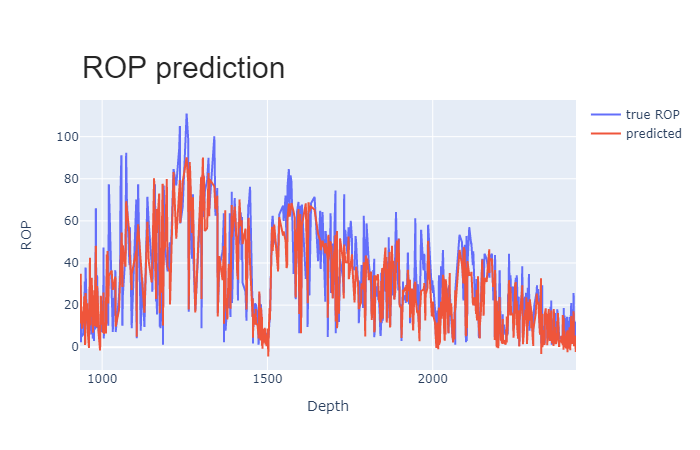

In [8]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter( x=depth_,y=rop_,
                    mode='lines',
                    name='true ROP'))
fig.add_trace(go.Scatter(y=pred_, x=depth_,
                    mode='lines',
                    name='predicted'))
# Title
fig.update_layout(
    annotations=annotations,
    yaxis=dict(title='ROP '),
    xaxis=dict(title='Depth'),
    width=1200
)
fig.show("png")

# History Graph 
is used to trace the overfitting and underfitting

Text(0, 0.5, 'MSE')

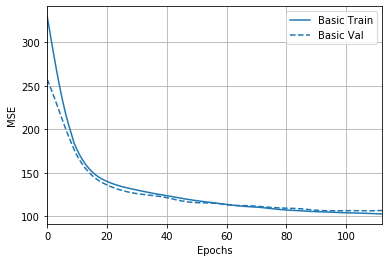

In [9]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'mse')    
plt.ylabel('MSE')

# accuracy: 77.69%